In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from umap import UMAP

# append the filepath to where torch is installed
sys.path.append('/home/millerm/.local/lib/python3.10/site-packages')
# sys.path.append('/home/username/.local/lib/python3.10/site-packages')

import torch
import torch.nn as nn
import torch.optim as optim

## Load and Preprocess Data

In [2]:
file_name = "ml4h_data/project2/project2_TS_input/mitbih_train.csv"
df_train = pd.read_csv(file_name,header=None)
x_train = df_train.iloc[:, df_train.columns != 187]
x_train = x_train.values.reshape(-1, 1, 187)
train_target = df_train.iloc[:, 187]
train_target = train_target.values
np.unique(train_target,return_counts=True)

(array([0., 1., 2., 3., 4.]), array([72471,  2223,  5788,   641,  6431]))

In [3]:
file_name = "ml4h_data/project2/project2_TS_input/mitbih_test.csv"
df_test = pd.read_csv(file_name,header=None)
x_test = df_test.iloc[:, df_test.columns != 187]
x_test = x_test.values.reshape(-1, 1, 187)
test_target = df_test.iloc[:, 187]
test_target = test_target.values
np.unique(test_target,return_counts=True)

(array([0., 1., 2., 3., 4.]), array([18118,   556,  1448,   162,  1608]))

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
from setsloaders import create_datasets, create_loaders, extract_embeddings, create_loaders_umap

In [6]:
datasets = create_datasets(x_train, x_test, train_target, test_target, seed=123)
trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

## Load and Train Model

In [7]:
input_channels = 1
num_classes = 5
train_loader = trn_dl
test_loader = tst_dl
num_epochs = 30
learning_rate = 0.005

In [8]:
class cnn(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.fc1 = nn.Linear(5376, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x, return_embedding=False):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)

        embedding = self.relu(self.fc1(x))
        
        if return_embedding:
            return embedding
        
        x = self.fc2(embedding)
        return x
        
model = cnn(input_channels, num_classes).to(device)

In [9]:
model = torch.load("models/vanillacnn.pth")
model = model.to(device)

In [10]:
model.fc2 = nn.Linear(128, 5, bias=True).to(device)

In [11]:
print(model)

cnn(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=5376, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss}")
        
model.eval()
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(predicted,labels)
        predicted = predicted.to("cpu")
        predictions = np.append(predictions,predicted)

    accuracy = 100 * correct / total
    print('Accuracy: {:.2f}%'.format(accuracy))

Epoch: 0, Loss: 0.08221717923879623
Epoch: 1, Loss: 0.058855775743722916
Epoch: 2, Loss: 0.07564529776573181
Epoch: 3, Loss: 0.03269977122545242
Epoch: 4, Loss: 0.10514610260725021
Epoch: 5, Loss: 0.06999073922634125
Epoch: 6, Loss: 0.04840806871652603
Epoch: 7, Loss: 0.06549559533596039
Epoch: 8, Loss: 0.06493660062551498
Epoch: 9, Loss: 0.03941630944609642
Epoch: 10, Loss: 0.010835655964910984
Epoch: 11, Loss: 0.05383870378136635
Epoch: 12, Loss: 0.0698729008436203
Epoch: 13, Loss: 0.017901452258229256
Epoch: 14, Loss: 0.012672904878854752
Epoch: 15, Loss: 0.004023746121674776
Epoch: 16, Loss: 0.01453409530222416
Epoch: 17, Loss: 0.014010434970259666
Epoch: 18, Loss: 0.07752593606710434
Epoch: 19, Loss: 0.0048828632570803165
Epoch: 20, Loss: 0.030944015830755234
Epoch: 21, Loss: 0.0341845378279686
Epoch: 22, Loss: 0.01114272978156805
Epoch: 23, Loss: 0.036221787333488464
Epoch: 24, Loss: 0.023520030081272125
Epoch: 25, Loss: 0.00601602578535676
Epoch: 26, Loss: 0.026221372187137604
E

In [13]:
model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

precision = precision_score(ground_truth, predictions, average="macro")
recall = recall_score(ground_truth, predictions, average="macro")
f1 = f1_score(ground_truth, predictions, average="macro")

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1-Score: {:.2f}'.format(f1))

Precision: 0.92
Recall: 0.89
F1-Score: 0.90


In [14]:
torch.save(model, "models/transfercnn_finetune_embedding_false.pth")

## Create Dataloaders

In [12]:
file_name = "ml4h_data/project2/project2_TS_input/ptbdb_train.csv"
df_train = pd.read_csv(file_name,header=None)
x_train = df_train.iloc[:, df_train.columns != 187]
x_train_ptb = x_train.values.reshape(-1, 1, 187)
train_target = df_train.iloc[:, 187]
train_target_ptb = train_target.values
train_target_ptb

array([1., 1., 0., ..., 1., 1., 1.])

In [13]:
file_name = "ml4h_data/project2/project2_TS_input/ptbdb_test.csv"
df_test = pd.read_csv(file_name,header=None)
x_test = df_test.iloc[:, df_test.columns != 187]
x_test_ptb = x_test.values.reshape(-1, 1, 187)
test_target = df_test.iloc[:, 187]
test_target_ptb = test_target.values
test_target_ptb

array([0., 1., 0., ..., 1., 1., 0.])

In [14]:
file_name = "ml4h_data/project2/project2_TS_input/mitbih_train.csv"
df_train = pd.read_csv(file_name,header=None)
x_train = df_train.iloc[:, df_train.columns != 187]
x_train_mit = x_train.values.reshape(-1, 1, 187)
train_target = df_train.iloc[:, 187]
train_target_mit = train_target.values
train_target_mit

array([0., 0., 0., ..., 4., 4., 4.])

In [15]:
file_name = "ml4h_data/project2/project2_TS_input/mitbih_test.csv"
df_test = pd.read_csv(file_name,header=None)
x_test = df_test.iloc[:, df_test.columns != 187]
x_test_mit = x_test.values.reshape(-1, 1, 187)
test_target = df_test.iloc[:, 187]
test_target_mit = test_target.values
test_target_mit

array([0., 0., 0., ..., 4., 4., 4.])

In [16]:
datasets_ptb = create_datasets(x_train_ptb, x_test_ptb, train_target_ptb, test_target_ptb, seed=123)
trn_dl_ptb, val_dl_ptb, tst_dl_ptb = create_loaders_umap(datasets_ptb, bs=128)

datasets_mit = create_datasets(x_train_mit, x_test_mit, train_target_mit, test_target_mit, seed=123)
trn_dl_mit, val_dl_mit, tst_dl_mit = create_loaders_umap(datasets_mit, bs=128)

In [17]:
train_loader_ptb = trn_dl_ptb
test_loader_ptb = tst_dl_ptb
train_loader_mit = trn_dl_mit
test_loader_mit = tst_dl_mit

In [18]:
all_labels_ptb_train = []
for images, labels in train_loader_ptb:
    all_labels_ptb_train.extend(labels.tolist())

all_labels_ptb_test = []
for images, labels in test_loader_ptb:
    all_labels_ptb_test.extend(labels.tolist())

In [19]:
all_labels_mit_train = []
for images, labels in test_loader_mit:
    all_labels_mit_train.extend(labels.tolist())

all_labels_mit_test = []
for images, labels in test_loader_mit:
    all_labels_mit_test.extend(labels.tolist())

In [21]:
palette = {0: "red",
           1: "blue",
           2: "green",
           3: "yellow",
           4: "purple"
          }
colors_ptb_train = [palette[label] for label in train_target_ptb]
colors_mit_train = [palette[label] for label in train_target_mit]
colors_ptb_test = [palette[label] for label in test_target_ptb]
colors_mit_test = [palette[label] for label in test_target_mit]

## Fine-Tune Model

In [22]:
model = torch.load("models/transfercnn_finetune_embedding_false.pth")
model_ptb = model.to(device)
model_mit = model.to(device)
model_ptb.fc2 = nn.Linear(128, 2, bias=True).to(device)

In [40]:
ptb_train = torch.tensor(x_train_ptb).float().to(device)
ptb_test = torch.tensor(x_test_ptb).float().to(device)
mit_train = torch.tensor(x_train_mit).float().to(device)
split = int(mit_train.shape[0] / 2)
mit_train_1 = mit_train[:split, :, :]
mit_train_2 = mit_train[split:, :, :]
mit_test = torch.tensor(x_test_mit).float().to(device)

model_ptb.eval()
with torch.no_grad():
    ptb_train_embeddings = model_ptb(ptb_train, return_embedding=True).cpu().numpy()
    ptb_test_embeddings = model_ptb(ptb_test, return_embedding=True).cpu().numpy()
model_mit.eval()
with torch.no_grad():
    mit_train_embeddings_1 = model_mit(mit_train_1, return_embedding=True).cpu().numpy()
    mit_train_embeddings_2 = model_mit(mit_train_2, return_embedding=True).cpu().numpy()
    mit_test_embeddings = model_mit(mit_test, return_embedding=True).cpu().numpy()

mit_train_embeddings = np.vstack((mit_train_embeddings_1, mit_train_embeddings_2))

In [41]:
np.save('data/ptb_train_embeddings.npy', ptb_train_embeddings)
np.save('data/ptb_test_embeddings.npy', ptb_test_embeddings)
np.save('data/mit_train_embeddings.npy', mit_train_embeddings)
np.save('data/mit_test_embeddings.npy', mit_test_embeddings)

In [45]:
def draw_umap(embeddings, colors, name_ds, train, s = 2, alpha = 0.5, random_state = 42):
    n_neighbors_values = [5, 15, 35]
    min_dist_values = [0.1, 0.5, 0.9]
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("PTB")

    for i, n_neighbors in enumerate(n_neighbors_values):
        for j, min_dist in enumerate(min_dist_values):
            emb = UMAP(n_neighbors = n_neighbors, min_dist = min_dist, random_state = random_state).fit_transform(embeddings)
            
            axs[i, j].scatter(emb[:, 0], emb[:, 1], c = colors, s = s, alpha = alpha)
            axs[i, j].set_title('{}: n_neighbors={}, min_dist={}'.format(name_ds, n_neighbors, min_dist))
            axs[i, j].set_xlabel('Dimension 1')
            axs[i, j].set_ylabel('Dimension 2')
            print('n_neighbors={}, min_dist={}'.format(n_neighbors, min_dist))

    if train == True:
        train = "train"
    else:
        train = "test"

    plt.tight_layout()
    plt.savefig(f"plots/umap_{name_ds}_{train}.png")
    plt.close()

In [23]:
mit_train_embeddings = np.load('data/mit_train_embeddings.npy')
mit_test_embeddings = np.load('data/mit_test_embeddings.npy')
ptb_train_embeddings = np.load('data/ptb_train_embeddings.npy')
ptb_test_embeddings = np.load('data/ptb_test_embeddings.npy')

In [44]:
draw_umap(ptb_test_embeddings, colors_ptb_test, "PTB", False)

/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.9


In [ ]:
draw_umap(ptb_train_embeddings, colors_ptb_train, "PTB", True)

/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [25]:
draw_umap(mit_train_embeddings, colors_mit_train, "MIT", True)

/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


n_neighbors=5, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.9


In [26]:
draw_umap(mit_test_embeddings, colors_mit_test, "MIT", False)

/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=5, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=15, min_dist=0.9


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.1


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.5


/cluster/courses/ml4h/jupyter/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


n_neighbors=35, min_dist=0.9


## KDE, KL and PCA

In [31]:
!pip install git+https://github.com/syrte/ndtest

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/syrte/ndtest to /tmp/pip-req-build-hs8sj2y5
  Running command git clone --filter=blob:none --quiet https://github.com/syrte/ndtest /tmp/pip-req-build-hs8sj2y5
  Resolved https://github.com/syrte/ndtest to commit 8b15ea9009148a4e124a1d3ecdc58216d765a05b
  Preparing metadata (setup.py) ... done
  Created wheel for ndtest: filename=ndtest-0.1-py3-none-any.whl size=5029 sha256=db3eb93e3099041afcc92f447af6581884098cb30f006d0149c92a253e868fdb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9mmjg89k/wheels/ff/81/f2/617b1190d5b86d01c2d80a870173cfead2d727180dfe452403
Successfully built ndtest


In [29]:
import ndtest
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

In [30]:
def compute_kl_divergence(data1, data2):
    # Create grid points where we estimate the densities
    min_values = np.minimum(np.min(data1, axis=0), np.min(data2, axis=0))
    max_values = np.maximum(np.max(data1, axis=0), np.max(data2, axis=0))

    num_points = 100  # Number of grid points in each dimension
    grid_points = [np.linspace(min_val, max_val, num_points) for min_val, max_val in zip(min_values, max_values)]
    grid = np.meshgrid(*grid_points)
    grid = np.vstack([g.ravel() for g in grid]).T
    
    # Estimate densities
    p = estimate_density(data1, grid)
    q = estimate_density(data2, grid)
    
    # Compute KL divergence
    kl_div = kl_divergence(p, q)
    
    return kl_div

In [31]:
def kl_divergence(p, q):
    # Ensure the densities are positive
    p = np.clip(p, 1e-10, None)
    q = np.clip(q, 1e-10, None)
    return np.sum(p * np.log(p / q))

def estimate_density(data, points):
    kde = gaussian_kde(data.T)
    return kde(points.T)

In [32]:
def kl_divergence_matrix(embeddings, lables):
    classes = np.unique(lables) 
    kl_matrix = np.zeros((len(classes), len(classes)))
    # diagonal is zero and symmetric
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            kl_matrix[i, j] = compute_kl_divergence(embeddings[lables == i], embeddings[lables == j])
            kl_matrix[j, i] = kl_matrix[i, j]
    return kl_matrix

### PCA

In [26]:
pca = PCA(n_components = 2)

In [44]:
pca_train_ptb_reduced = pca.fit_transform(ptb_train_embeddings)
pca_test_ptb_reduced = pca.transform(ptb_test_embeddings)
pca_train_mit_reduced = pca.fit_transform(mit_train_embeddings)
pca_test_mit_reduced = pca.transform(mit_test_embeddings)

In [45]:
matrix_train = kl_divergence_matrix(pca_train_mit_reduced, train_target_mit)
matrix_test = kl_divergence_matrix(pca_test_mit_reduced, test_target_mit)

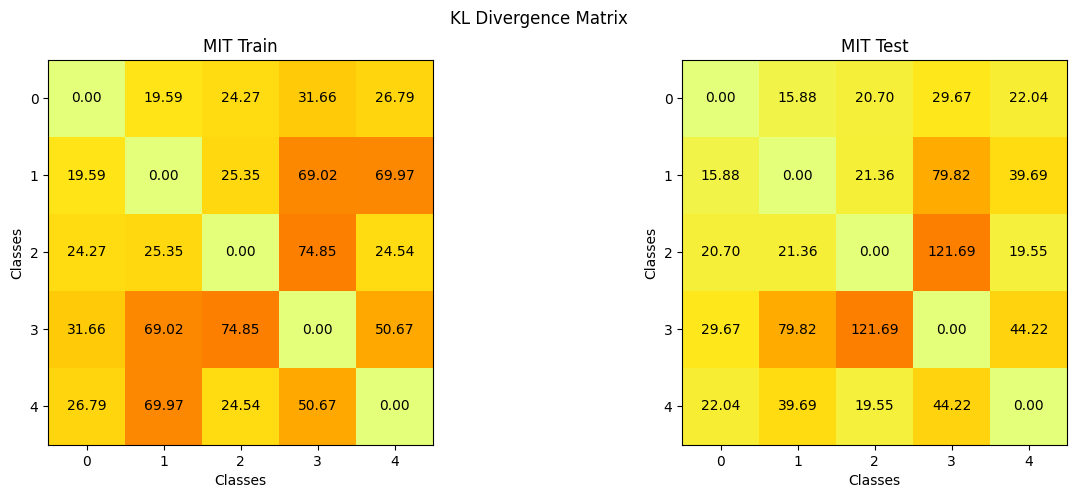

In [46]:
# mit_reduced

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('KL Divergence Matrix')
axs[0].imshow(matrix_train, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(matrix_train.shape[0]):
    for j in range(matrix_train.shape[1]):
        axs[0].text(j, i, f'{matrix_train[i, j]:.2f}', ha='center', va='center', color='black')

axs[0].set_title('MIT Train')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Classes')
axs[1].imshow(matrix_test, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(matrix_test.shape[0]):
    for j in range(matrix_test.shape[1]):
        axs[1].text(j, i, f'{matrix_test[i, j]:.2f}', ha='center', va='center', color='black')

axs[1].set_title('MIT Test')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Classes')
plt.savefig("plots/kl_matrix_mit.png")
plt.show()

In [47]:
matrix_train = kl_divergence_matrix(pca_train_ptb_reduced, train_target_ptb)
matrix_test = kl_divergence_matrix(pca_test_ptb_reduced, test_target_ptb)

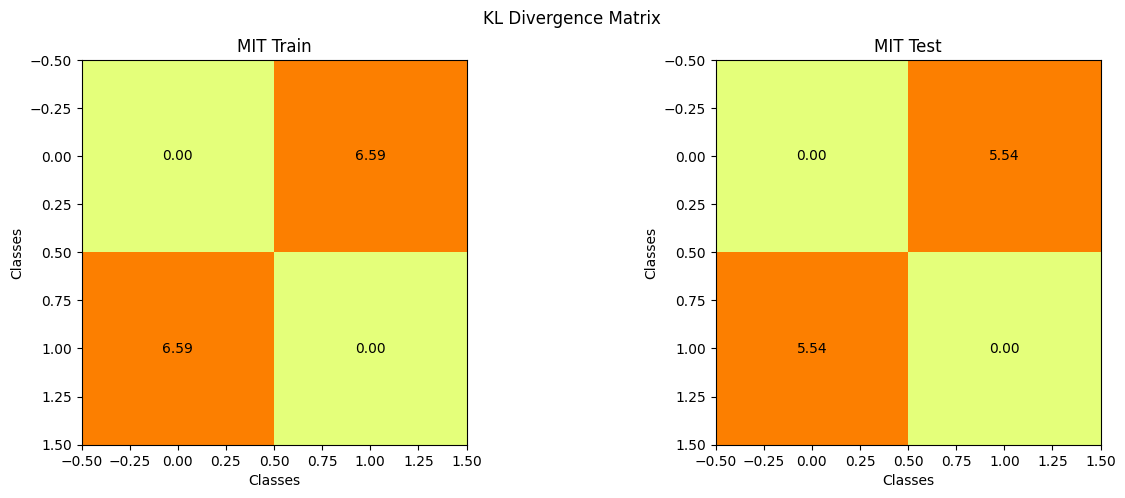

In [48]:
# ptb_reduced

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('KL Divergence Matrix')
axs[0].imshow(matrix_train, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(matrix_train.shape[0]):
    for j in range(matrix_train.shape[1]):
        axs[0].text(j, i, f'{matrix_train[i, j]:.2f}', ha='center', va='center', color='black')

axs[0].set_title('MIT Train')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Classes')
axs[1].imshow(matrix_test, cmap='Wistia', interpolation='nearest')

# Add the values in the squares
for i in range(matrix_test.shape[0]):
    for j in range(matrix_test.shape[1]):
        axs[1].text(j, i, f'{matrix_test[i, j]:.2f}', ha='center', va='center', color='black')

axs[1].set_title('MIT Test')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Classes')
plt.savefig("plots/kl_matrix_mit.png")
plt.show()

In [50]:
#calculate the Kl divergence between the mit and ptb data all combinations
kl_mit_ptb_train = compute_kl_divergence(pca_train_mit_reduced, pca_train_ptb_reduced)
kl_mit_ptb_test = compute_kl_divergence(pca_test_mit_reduced, pca_test_ptb_reduced)
kl_mit_ptb_train_test = compute_kl_divergence(pca_train_mit_reduced, pca_test_ptb_reduced)
kl_mit_ptb_test_train = compute_kl_divergence(pca_test_mit_reduced, pca_train_ptb_reduced)
kl_mit = compute_kl_divergence(pca_train_mit_reduced, pca_test_mit_reduced)
kl_ptb = compute_kl_divergence(pca_train_ptb_reduced, pca_test_ptb_reduced)

# print results in a table
print('KL Divergence')
print('MIT Train vs PTB Train:', kl_mit_ptb_train)
print('MIT Test vs PTB Test:', kl_mit_ptb_test)
print('MIT Train vs PTB Test:', kl_mit_ptb_train_test)
print('MIT Test vs PTB Train:', kl_mit_ptb_test_train)
print('MIT Train vs MIT Test:', kl_mit)
print('PTB Train vs PTB Test:', kl_ptb)

KL Divergence
MIT Train vs PTB Train: 3.7555742136250694
MIT Test vs PTB Test: 3.5269123278873975
MIT Train vs PTB Test: 3.3995507964722687
MIT Test vs PTB Train: 3.9198684212578727
MIT Train vs MIT Test: 0.013540669998990687
PTB Train vs PTB Test: 0.06047400402479906


In [51]:
# perform the two-sample test
mit_ptb_train = ndtest.ks2d2s(pca_train_mit_reduced[:,0], pca_train_mit_reduced[:,1], pca_train_ptb_reduced[:,0], pca_train_ptb_reduced[:,1])
mit_ptb_test = ndtest.ks2d2s(pca_test_mit_reduced[:,0], pca_test_mit_reduced[:,1], pca_test_ptb_reduced[:,0], pca_test_ptb_reduced[:,1])
mit_ptb_train_test = ndtest.ks2d2s(pca_train_mit_reduced[:,0], pca_train_mit_reduced[:,1], pca_test_ptb_reduced[:,0], pca_test_ptb_reduced[:,1])
mit_ptb_test_train = ndtest.ks2d2s(pca_test_mit_reduced[:,0], pca_test_mit_reduced[:,1], pca_train_ptb_reduced[:,0], pca_train_ptb_reduced[:,1])
mit = ndtest.ks2d2s(pca_train_mit_reduced[:,0], pca_train_mit_reduced[:,1], pca_test_mit_reduced[:,0], pca_test_mit_reduced[:,1])
ptb = ndtest.ks2d2s(pca_train_ptb_reduced[:,0], pca_train_ptb_reduced[:,1], pca_test_ptb_reduced[:,0], pca_test_ptb_reduced[:,1])

# print results in a table
print('Two-sample test')
print('MIT Train vs PTB Train:', mit_ptb_train)
print('MIT Test vs PTB Test:', mit_ptb_test)
print('MIT Train vs PTB Test:', mit_ptb_train_test)
print('MIT Test vs PTB Train:', mit_ptb_test_train)
print('MIT Train vs MIT Test:', mit)
print('PTB Train vs PTB Test:', ptb)

Two-sample test
MIT Train vs PTB Train: 2.311871636840386e-224
MIT Test vs PTB Test: 2.182343977754287e-56
MIT Train vs PTB Test: 1.177927283826321e-60
MIT Test vs PTB Train: 3.4635356028541625e-169
MIT Train vs MIT Test: 0.24907695561001233
PTB Train vs PTB Test: 0.6194542545347974
